The data comes from https://firstratedata.com/, but their free samples seem to be tied to the day you request to have them.

I tried to find stocks in different fields.

I didn't feel the need to test for trends because my window is so short (just a couple of weeks)

I chose to use GRU based on this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141105/#:~:text=2.4.-,Recurrent%20Neural%20Networks%20(RNNs),time%20intervals%20or%20time%20steps. Long Term Short Term networks may also work but they may be time intensive. "GRUs are simplified version of LSTMs that use single “update gate” to control the flow of information into the memory cell. GRUs are easier to train and faster to run than LSTMs, but they may not be as effective at storing and accessing long-term dependencies."

I have access to 10 days worth of minute-to-minute data, for 7 stocks in different fields. I used a "walk forward" stratedy to train my models: giving it two and a half days worth of data (from 8am day 1 to 11:59am on day 3) and then asked it to predict the price at noon, 2pm, and the closing price at 4pm on day 3. Once the model was tuned, I had it work from day 1 into the middle of day 4, and so on until the final day's worth of data was reached (the test set).

Remember: Convert change in price to percentage

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
#!pip install numpy==1.23.0
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import keras

In [2]:
print(np.__version__)

1.25.2


In [3]:
df_aal = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/AAL_1min_sample.csv")
df_fdx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FDX_1min_sample.csv")
df_fis = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FIS_1min_sample.csv")
df_mcy = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/M_1min_sample.csv")
df_spr = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/S_1min_sample.csv")
df_sbx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/SBUX_1min_sample.csv")
df_tsl = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/TSLA_1min_sample.csv")

all_dfs = [df_aal, df_fdx, df_fis, df_mcy, df_sbx, df_spr, df_tsl]

In [4]:
for df in all_dfs:
    print(len(df))

5700
4231
4396
5595
4776
5050
10005


In [5]:
for df in all_dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
# for df in all_dfs:
#     print(df.isnull().sum())
#     print("\n")

Next, I am just looking for the latest time that any of my stocks began to track their prices and the earliest time that any of them stopped tracking their prices. This way, I can make all of my data uniform in length.

In [7]:
for df in all_dfs:
    print(df["timestamp"][0])

2024-02-26 04:03:00
2024-02-26 06:09:00
2024-02-26 06:06:00
2024-02-26 04:41:00
2024-02-26 08:00:00
2024-02-26 04:00:00
2024-02-26 04:00:00


In [8]:
for df in all_dfs:
    print(df["timestamp"].iloc[-1])

2024-03-11 19:44:00
2024-03-11 18:11:00
2024-03-11 16:00:00
2024-03-11 19:39:00
2024-03-11 19:04:00
2024-03-11 19:38:00
2024-03-11 19:54:00


So 8am on the 26th and 4pm on the 11th.

In [9]:
for df in all_dfs:
    df.set_index('timestamp', inplace=True)

In [10]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df.resample("1min").asfreq().ffill()

In [11]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df['2024-02-26 08:00' : "2024-03-11 16:00" ]

In [12]:
for i, df in enumerate(all_dfs):
    all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)

In [13]:
seven_dfs = pd.concat(all_dfs, axis=1)

In [14]:
cols = ["open_1", "volume_1", "open_2", "volume_2", "open_3",
                   "volume_3", "open_4", "volume_4", "open_5", "volume_5",
                   "open_6", "volume_6", "open_7", "volume_7"]

seven_dfs.set_axis(cols, axis = 1, inplace = True)

<ipython-input-14-af5447aa6638>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  seven_dfs.set_axis(cols, axis = 1, inplace = True)


In [15]:
# Getting the first one and a half days of data for the initial training set,
# Then using that to scale all of my data.


train_36_hrs = seven_dfs['2024-02-26 08:00' : "2024-02-28 12:00" ]

scaler = StandardScaler()

train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])
seven_dfs[cols] = scaler.transform(seven_dfs[cols])

<ipython-input-15-5950431c8b46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])


In [16]:
seven_dfs["hour"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["hour"][i] = seven_dfs.index[i].hour

seven_dfs["day"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["day"][i] = seven_dfs.index[i].dayofweek

In [17]:
seven_dfs.drop(seven_dfs[(seven_dfs["hour"] < 8) |
                        (seven_dfs["hour"] > 15)].index, inplace = True)
seven_dfs.drop(seven_dfs[seven_dfs["day"] > 4].index, inplace = True)

In [18]:
len(seven_dfs)

5280

<Axes: xlabel='timestamp'>

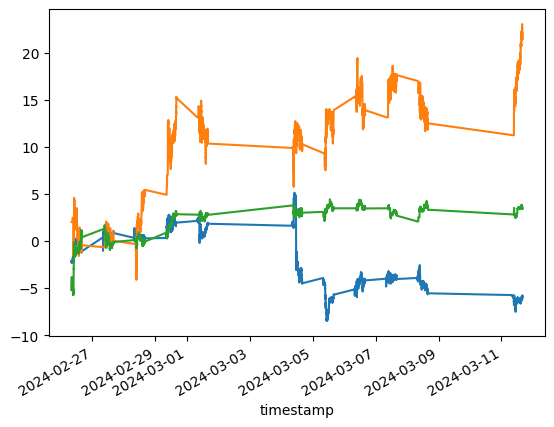

In [19]:
seven_dfs.open_1.plot()
seven_dfs.open_2.plot()
seven_dfs.open_3.plot()

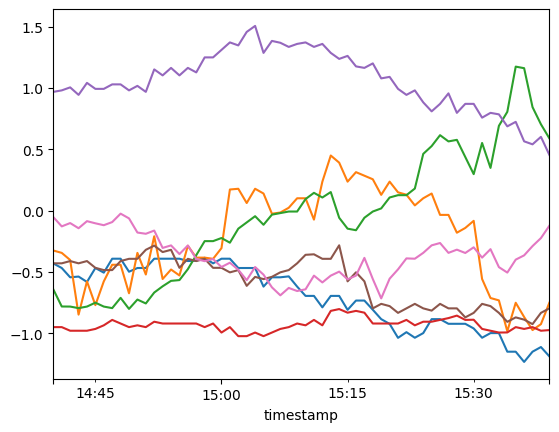

In [20]:
prices = ["open_1", "open_2", "open_3", "open_4", "open_5", "open_6", "open_7"]
for price in prices:
  seven_dfs[price][400:460].plot()

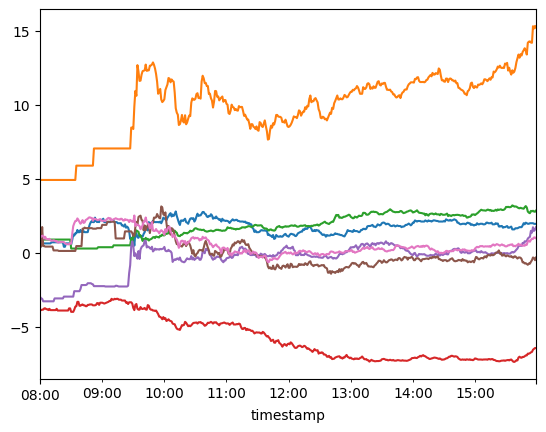

In [21]:
for price in prices:
  seven_dfs[price][1440:1920].plot()

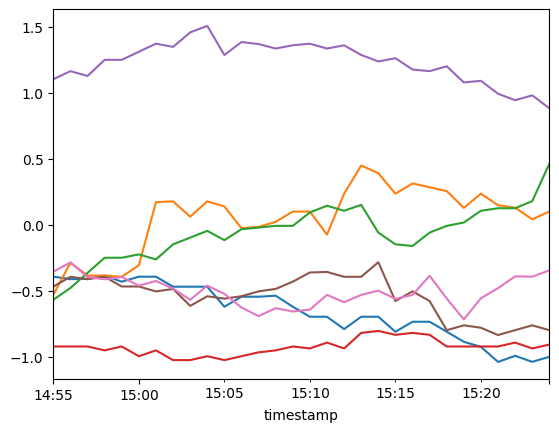

In [22]:
for price in prices:
  seven_dfs[price][415:445].plot()

In [23]:
seven_dfs.drop(seven_dfs[seven_dfs["hour"] < 9].index, inplace = True)

In [24]:
len(seven_dfs)

4620

In [25]:
seven_dfs.head()

,open_1,volume_1,open_2,volume_2,open_3,volume_3,open_4,volume_4,open_5,volume_5,open_6,volume_6,open_7,volume_7,hour,day
timestamp,,,,,,,,,,,,,,,,
2024-02-26 09:00:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.248041,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.676290,-0.515833,9.0,0.0
2024-02-26 09:01:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.676290,-0.509867,9.0,0.0
2024-02-26 09:02:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.552663,-0.246766,3.020294,-0.089569,-3.440951,-0.079279,-3.691343,-0.499595,9.0,0.0
2024-02-26 09:03:00,-1.718825,-0.227184,2.481364,-0.532078,-4.453081,-0.169387,-0.523226,-0.225539,3.020294,-0.089569,-3.440951,-0.079279,-3.671273,-0.508306,9.0,0.0
2024-02-26 09:04:00,-2.022018,-0.228474,2.481364,-0.532078,-4.453081,-0.169387,-0.523226,-0.225539,3.020294,-0.089569,-3.440951,-0.079279,-3.696360,-0.457163,9.0,0.0


In [26]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=c0k-YLQGKjY
def df_to_Xy(df, window):
  df_np = df.to_numpy()
  X = []
  y = []
  for i in range(0, len(df)-window, window):
    row = [a for a in df_np[i:i+window]]
    X.append(row)
    y.append(df_np[i+window][[0,2,4,6,8,10,12]]) # y is just the 7 price cols
  return np.array(X), np.array(y,dtype=np.float32)

In [27]:
X25, y25 = df_to_Xy(seven_dfs, 25)
X34, y34 = df_to_Xy(seven_dfs, 34)
X45, y45 = df_to_Xy(seven_dfs, 45)
X60, y60 = df_to_Xy(seven_dfs, 60)

When I first started building these, before I fully realized how I wanted the iteration process to go, my intervals were 34, 45, 60, and 80. But it became quite apparent that the 80 minute intervals were beyond saving (presumably because they didn't have enough instances of the target variable in the training data). So I added the 25 minute one in its place.

In [28]:
len(y25)

184

In [29]:
X_train25, y_train25 = X25[:129], y25[:129] #Just over 70% of the data
X_val25, y_val25 = X25[129:157], y25[129:157]
X_test25, y_test25 = X25[157:], y25[157:]

X_train34, y_train34 = X34[:95], y34[:95]
X_val34, y_val34 = X34[95:115], y34[95:115]
X_test34, y_test34 = X34[115:], y34[115:]

X_train45, y_train45 = X45[:72], y45[:72]
X_val45, y_val45 = X45[72:87], y45[72:87]
X_test45, y_test45 = X45[87:], y45[87:]

X_train60, y_train60 = X60[:55], y60[:55]
X_val60, y_val60 = X60[55:65], y60[55:65]
X_test60, y_test60 = X60[65:], y60[65:]

In [69]:
def pred_plot_col(model, X, y, col):
  y = y[:,col]
  preds = model.predict(X)[:,col].flatten()
  df = pd.DataFrame(data={"Predictions":preds, "Actuals":y})
  plt.plot(df["Predictions"][:], label = "Predictions")
  plt.plot(df["Actuals"][:], label = "Actuals")
  plt.legend()
  return mse(y, preds)

def pred_plot_all(model, X, y):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
  fig.set_figheight(22)
  fig.set_figwidth(15)
  axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
  for i, ax in enumerate(axes):
    actual = y[:,i].flatten()
    preds = model.predict(X)[:,i].flatten()
    ax = ax
    ax.plot(preds)
    ax.plot(actual)
    ax.legend(["Prediction", "Actual"])
    plt.legend()
  plt.show()

In [31]:
def plot_error(history):
  hist_dict = history.history
  rmse = hist_dict["root_mean_squared_error"]
  v_rmse = hist_dict["val_root_mean_squared_error"]
  df = pd.DataFrame(data={"Train_error":rmse, "Val_Error":v_rmse})
  plt.plot(df["Train_error"][:], label = "Train error")
  plt.plot(df["Val_Error"][:], label = "Val Error")
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

I chose two variables to adjust, and each one has two states:

Learning rate, which is either
Default (0.0001) or Fast (0.01).
Number of hidden layers: Short (2) vs Long (4)

In [32]:
# All of the training and validation datasets
the_X_trains = [X_train25, X_train34, X_train45, X_train60]
the_y_trains = [y_train25, y_train34, y_train45, y_train60]

the_X_vals = [X_val25, X_val34, X_val45, X_val60]
the_y_vals = [y_val25, y_val34, y_val45, y_val60]


## Instantiating models, checkpoints, and what will be their histories,
## then putting all of them in lists

# Default/Short
mod_25_DeSh = Sequential()
mod_34_DeSh = Sequential()
mod_45_DeSh = Sequential()
mod_60_DeSh = Sequential()

cp_25_DeSh = ModelCheckpoint("model_25_DeSh/", save_best_only=True)
cp_34_DeSh = ModelCheckpoint("model_34_DeSh/", save_best_only=True)
cp_45_DeSh = ModelCheckpoint("model_45_DeSh/", save_best_only=True)
cp_60_DeSh = ModelCheckpoint("model_60_DeSh/", save_best_only=True)

hist_25_DeSh = None
hist_34_DeSh = None
hist_45_DeSh = None
hist_60_DeSh = None

mods_DeSh = [mod_25_DeSh, mod_34_DeSh, mod_45_DeSh, mod_60_DeSh]

cps_DeSh = [cp_25_DeSh, cp_34_DeSh, cp_45_DeSh, cp_60_DeSh]

hists_DeSh = [hist_25_DeSh, hist_34_DeSh, hist_45_DeSh, hist_60_DeSh]

# Fast/Short
mod_25_FaSh = Sequential()
mod_34_FaSh = Sequential()
mod_45_FaSh = Sequential()
mod_60_FaSh = Sequential()

cp_25_FaSh = ModelCheckpoint("model_25_FaSh/", save_best_only=True)
cp_34_FaSh = ModelCheckpoint("model_34_FaSh/", save_best_only=True)
cp_45_FaSh = ModelCheckpoint("model_45_FaSh/", save_best_only=True)
cp_60_FaSh = ModelCheckpoint("model_60_FaSh/", save_best_only=True)

hist_25_FaSh = None
hist_34_FaSh = None
hist_45_FaSh = None
hist_60_FaSh = None

mods_FaSh = [mod_25_FaSh, mod_34_FaSh, mod_45_FaSh, mod_60_FaSh]

cps_FaSh = [cp_25_FaSh, cp_34_FaSh, cp_45_FaSh, cp_60_FaSh]

hists_FaSh = [hist_25_FaSh, hist_34_FaSh, hist_45_FaSh, hist_60_FaSh]

# Default/Long
mod_25_DeLo = Sequential()
mod_34_DeLo = Sequential()
mod_45_DeLo = Sequential()
mod_60_DeLo = Sequential()

cp_25_DeLo = ModelCheckpoint("model_25_DeLo/", save_best_only=True)
cp_34_DeLo = ModelCheckpoint("model_34_DeLo/", save_best_only=True)
cp_45_DeLo = ModelCheckpoint("model_45_DeLo/", save_best_only=True)
cp_60_DeLo = ModelCheckpoint("model_60_DeLo/", save_best_only=True)

hist_25_DeLo = None
hist_34_DeLo = None
hist_45_DeLo = None
hist_60_DeLo = None

mods_DeLo = [mod_25_DeLo, mod_34_DeLo, mod_45_DeLo, mod_60_DeLo]

cps_DeLo = [cp_25_DeLo, cp_34_DeLo, cp_45_DeLo, cp_60_DeLo]

hists_DeLo = [hist_25_DeLo, hist_34_DeLo, hist_45_DeLo, hist_60_DeLo]

# Fast/Long
mod_25_FaLo = Sequential()
mod_34_FaLo = Sequential()
mod_45_FaLo = Sequential()
mod_60_FaLo = Sequential()

cp_25_FaLo = ModelCheckpoint("model_25_FaLo/", save_best_only=True)
cp_34_FaLo = ModelCheckpoint("model_34_FaLo/", save_best_only=True)
cp_45_FaLo = ModelCheckpoint("model_45_FaLo/", save_best_only=True)
cp_60_FaLo = ModelCheckpoint("model_60_FaLo/", save_best_only=True)

hist_25_FaLo = None
hist_34_FaLo = None
hist_45_FaLo = None
hist_60_FaLo = None

mods_FaLo = [mod_25_FaLo, mod_34_FaLo, mod_45_FaLo, mod_60_FaLo]

cps_FaLo = [cp_25_FaLo, cp_34_FaLo, cp_45_FaLo, cp_60_FaLo]

hists_FaLo = [hist_25_FaLo, hist_34_FaLo, hist_45_FaLo, hist_60_FaLo]

For the models with an accelerated learning rate, I gave them a maximum of 25 epochs to train. The default learning rate was given 100 epochs. These slower models were also given a little more leeway with the early stopping parameter (patience = 5 instead of 3, start_from_epoch = 10 instead of 5).

In [33]:
# Default and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeSh[i].add(InputLayer((n,16)))
  mods_DeSh[i].add(GRU(64))
  mods_DeSh[i].add(Dense(16, "relu"))
  mods_DeSh[i].add(Dense(14, "relu"))
  mods_DeSh[i].add(Dense(7, "linear"))

  mods_DeSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Short, samples = " + str(n))
  hists_DeSh[i] = mods_DeSh[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 180,
      callbacks = [cps_DeSh[i], EarlyStopping(patience=5, start_from_epoch=10)])

  print("\n")
  print("\n")

Default and Short, samples = 25
Epoch 1/180
5/5 [==============================] - 8s 1s/step - loss: 26.0587 - root_mean_squared_error: 5.1048 - val_loss: 68.1612 - val_root_mean_squared_error: 8.2560
Epoch 2/180
5/5 [==============================] - 4s 872ms/step - loss: 25.8442 - root_mean_squared_error: 5.0837 - val_loss: 67.7718 - val_root_mean_squared_error: 8.2324
Epoch 3/180
5/5 [==============================] - 4s 939ms/step - loss: 25.6552 - root_mean_squared_error: 5.0651 - val_loss: 67.3693 - val_root_mean_squared_error: 8.2079
Epoch 4/180
5/5 [==============================] - 4s 986ms/step - loss: 25.4757 - root_mean_squared_error: 5.0473 - val_loss: 66.9824 - val_root_mean_squared_error: 8.1843
Epoch 5/180
5/5 [==============================] - 4s 1s/step - loss: 25.3190 - root_mean_squared_error: 5.0318 - val_loss: 66.6074 - val_root_mean_squared_error: 8.1613
Epoch 6/180
5/5 [==============================] - 3s 868ms/step - loss: 25.1611 - root_mean_squared_error: 5

In [125]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_DeSh[i].history['val_root_mean_squared_error'])
  ) + " = Default/Short best Val RMSE with samples sized " + str(n))
  print("\n")

2.512178421020508 = Default/Short best Val RMSE with samples sized 25


5.879482746124268 = Default/Short best Val RMSE with samples sized 34


4.9782867431640625 = Default/Short best Val RMSE with samples sized 45


6.107494831085205 = Default/Short best Val RMSE with samples sized 60




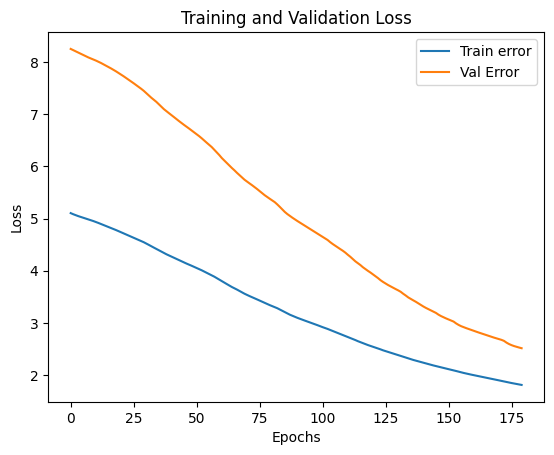

In [61]:
plot_error(hists_DeSh[0])

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 38ms/step


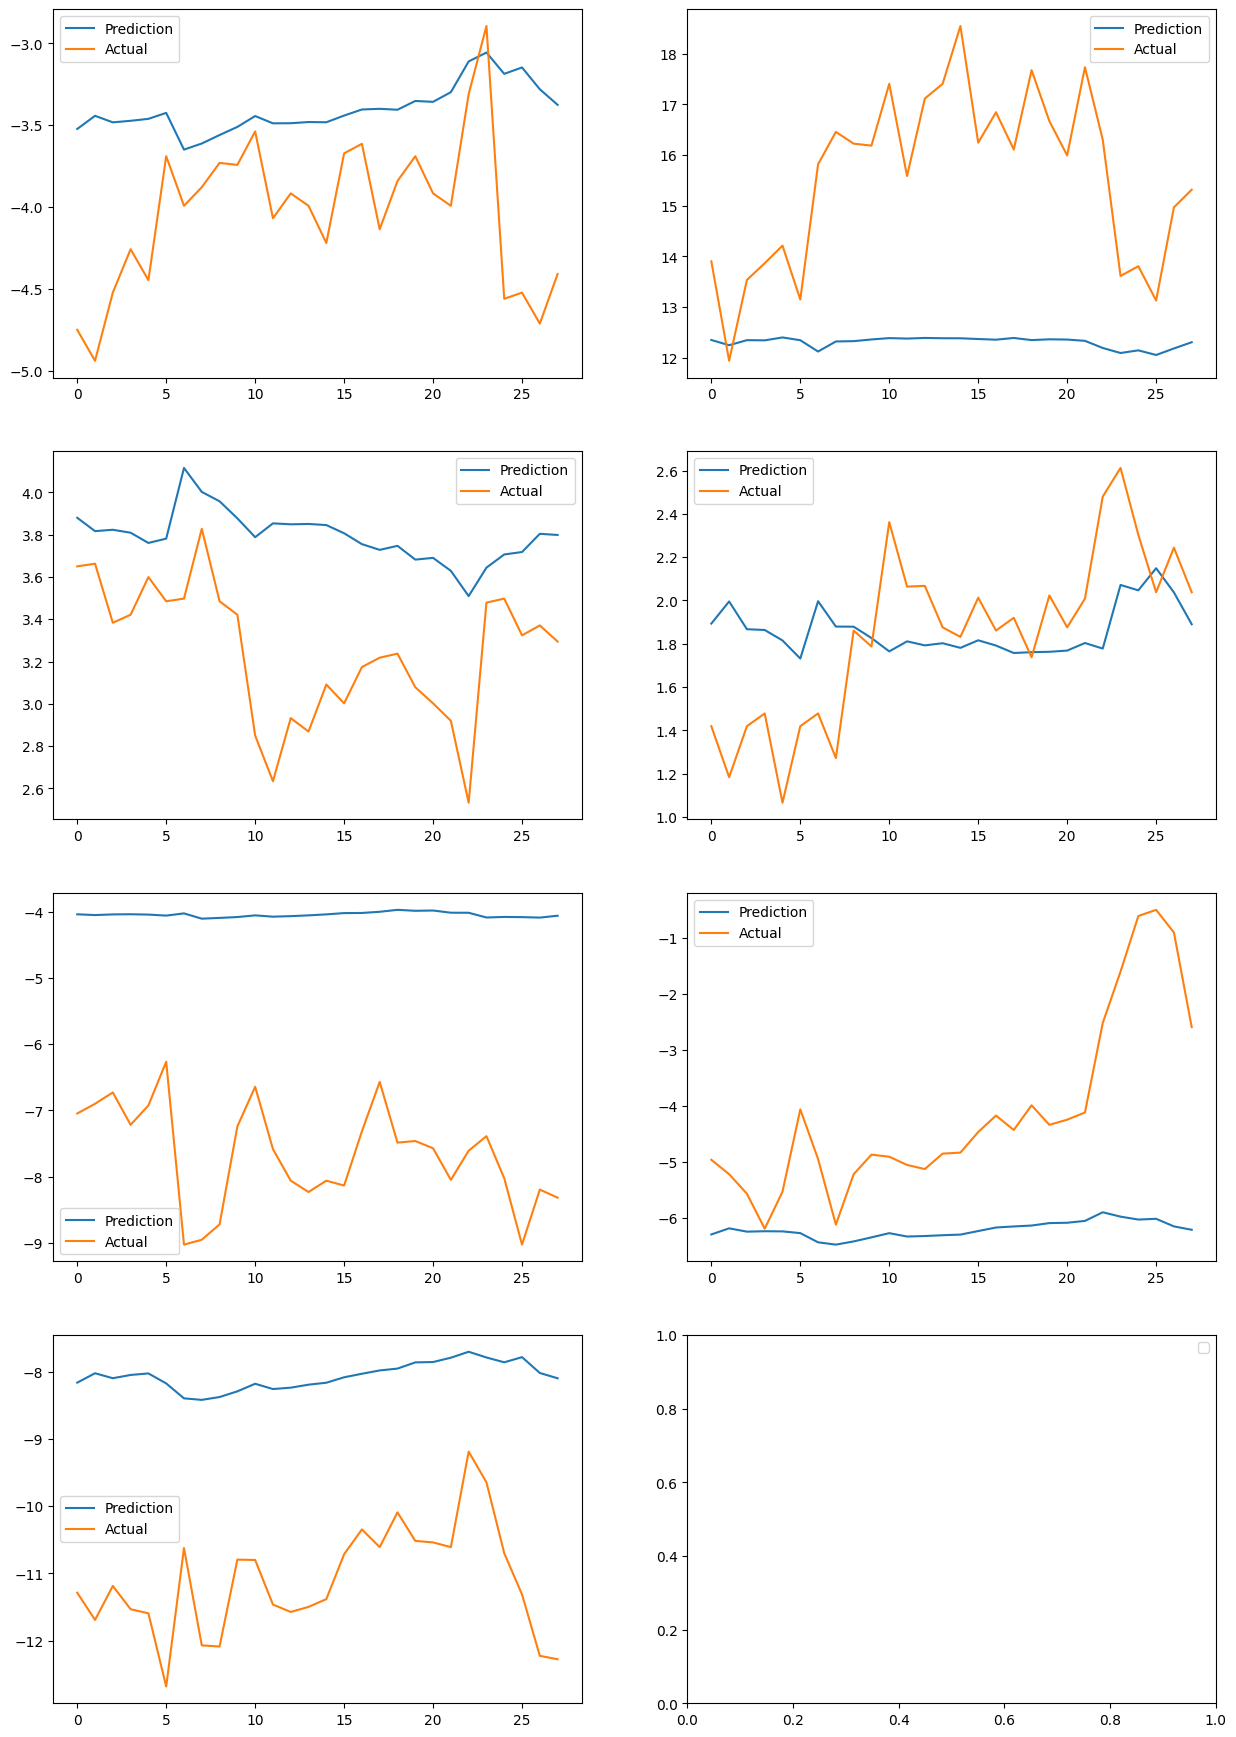

In [70]:
pred_plot_all(mod_25_DeSh, X_val25, y_val25)

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 141ms/step


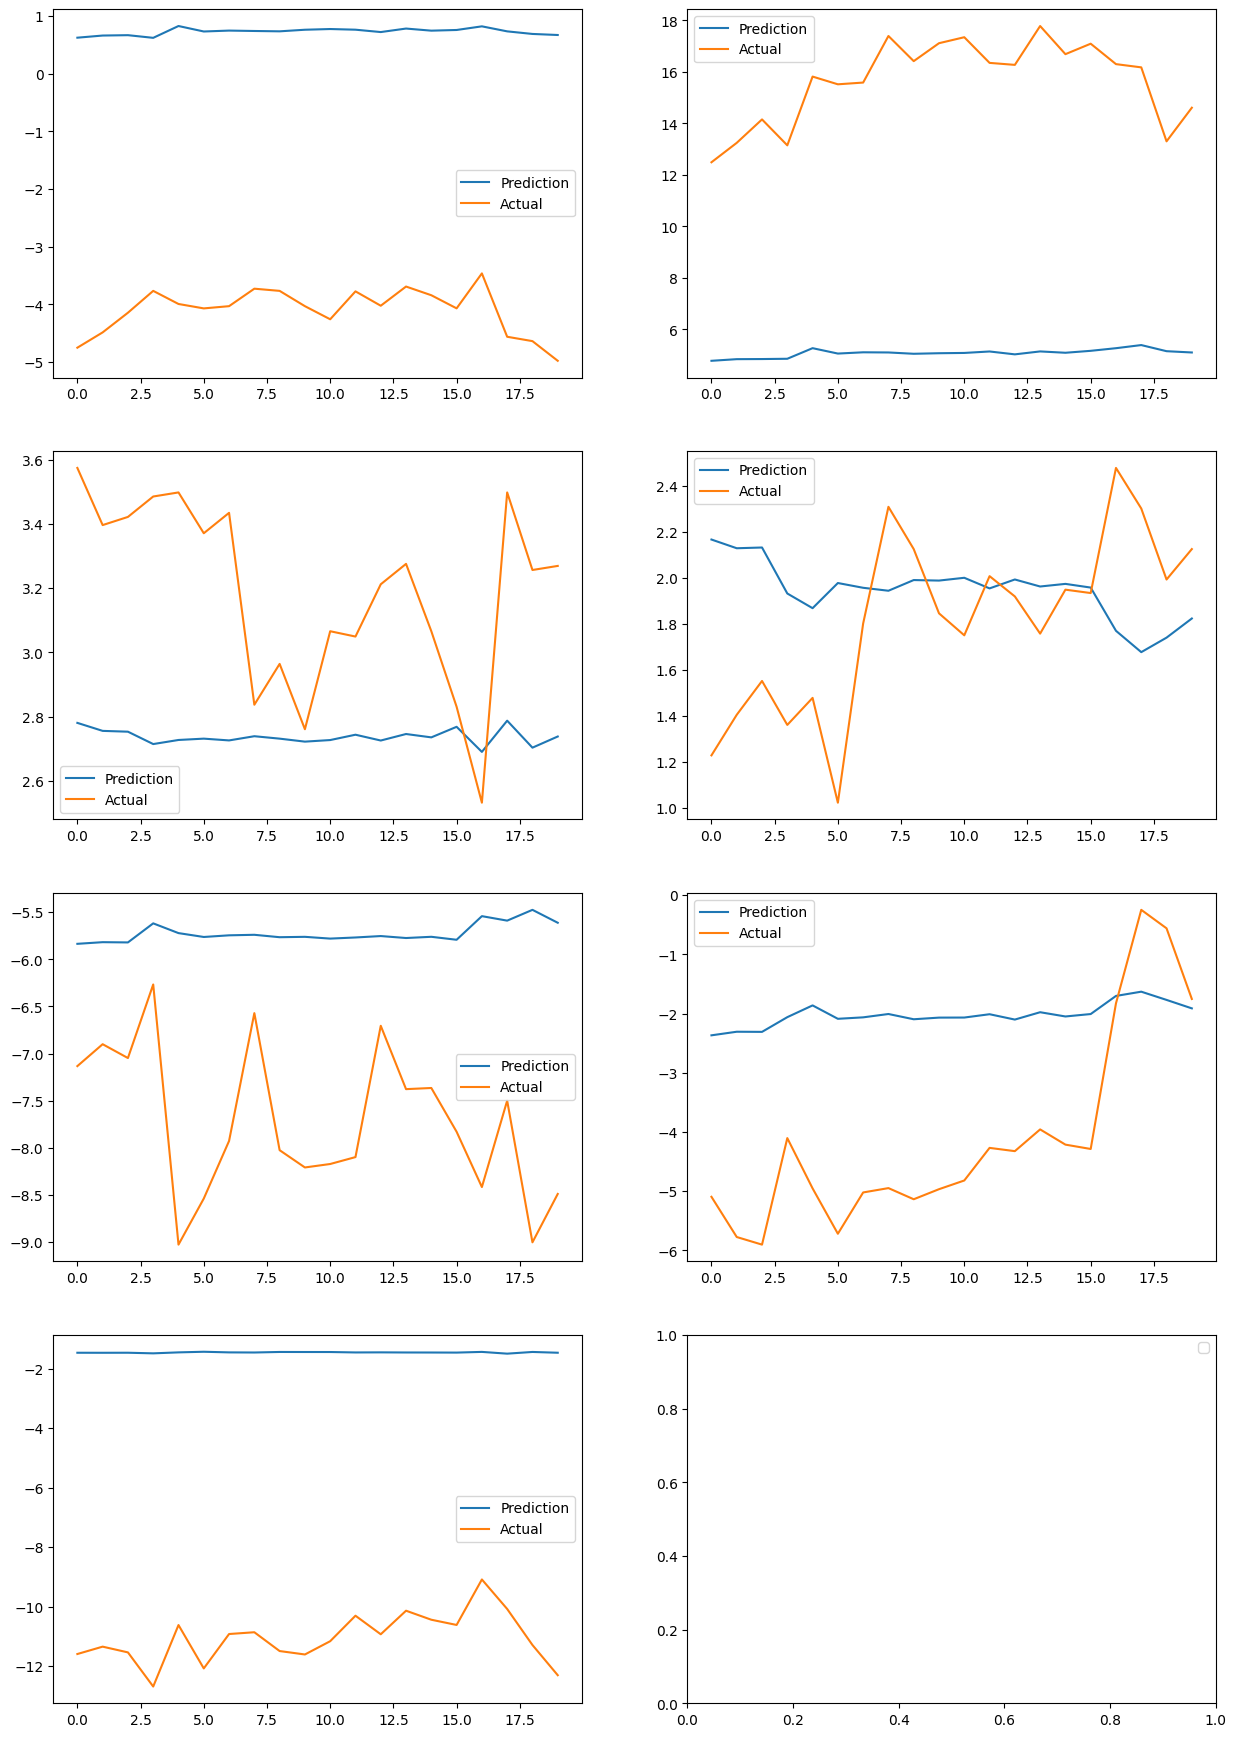

In [66]:
pred_plot_all(mod_34_DeSh, X_val34, y_val34)

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 91ms/step


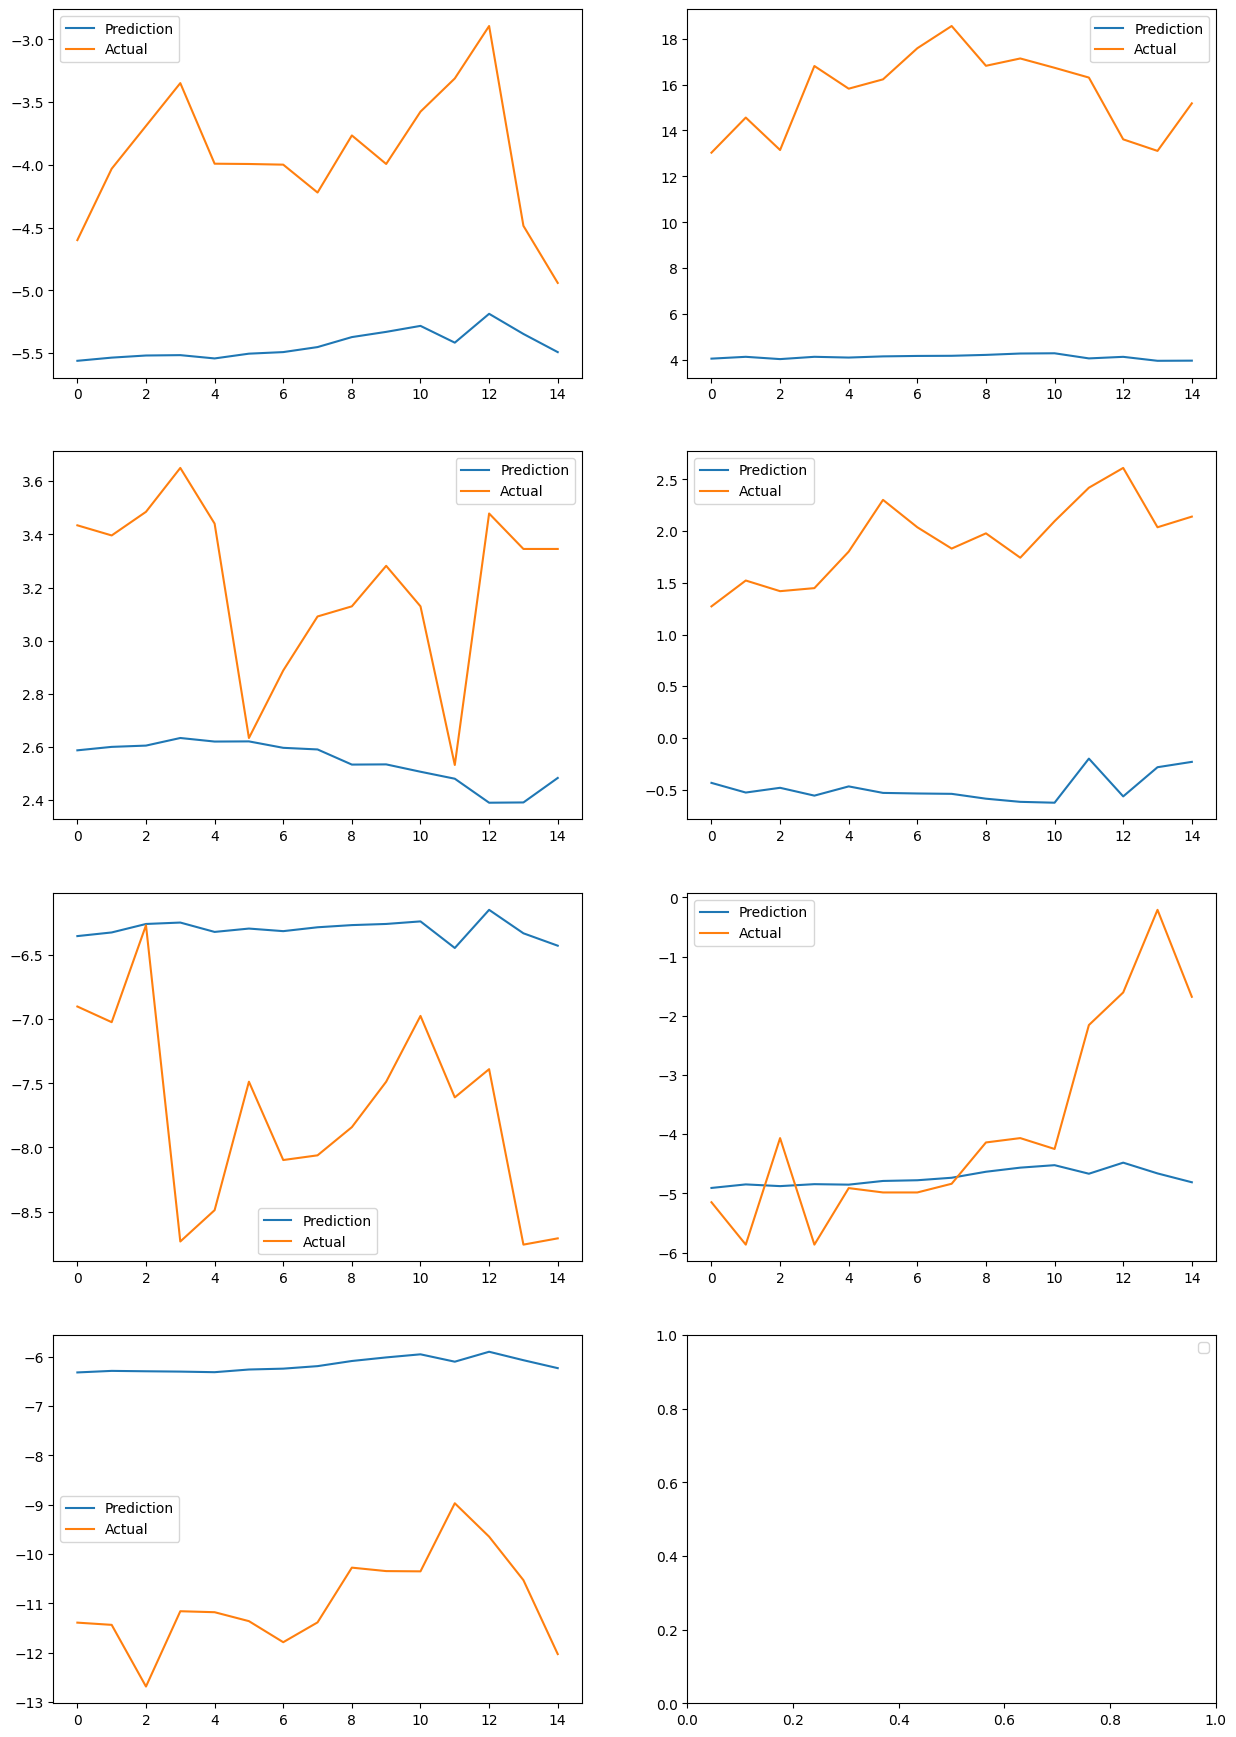

In [71]:
pred_plot_all(mod_45_DeSh, X_val45, y_val45)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 105ms/step


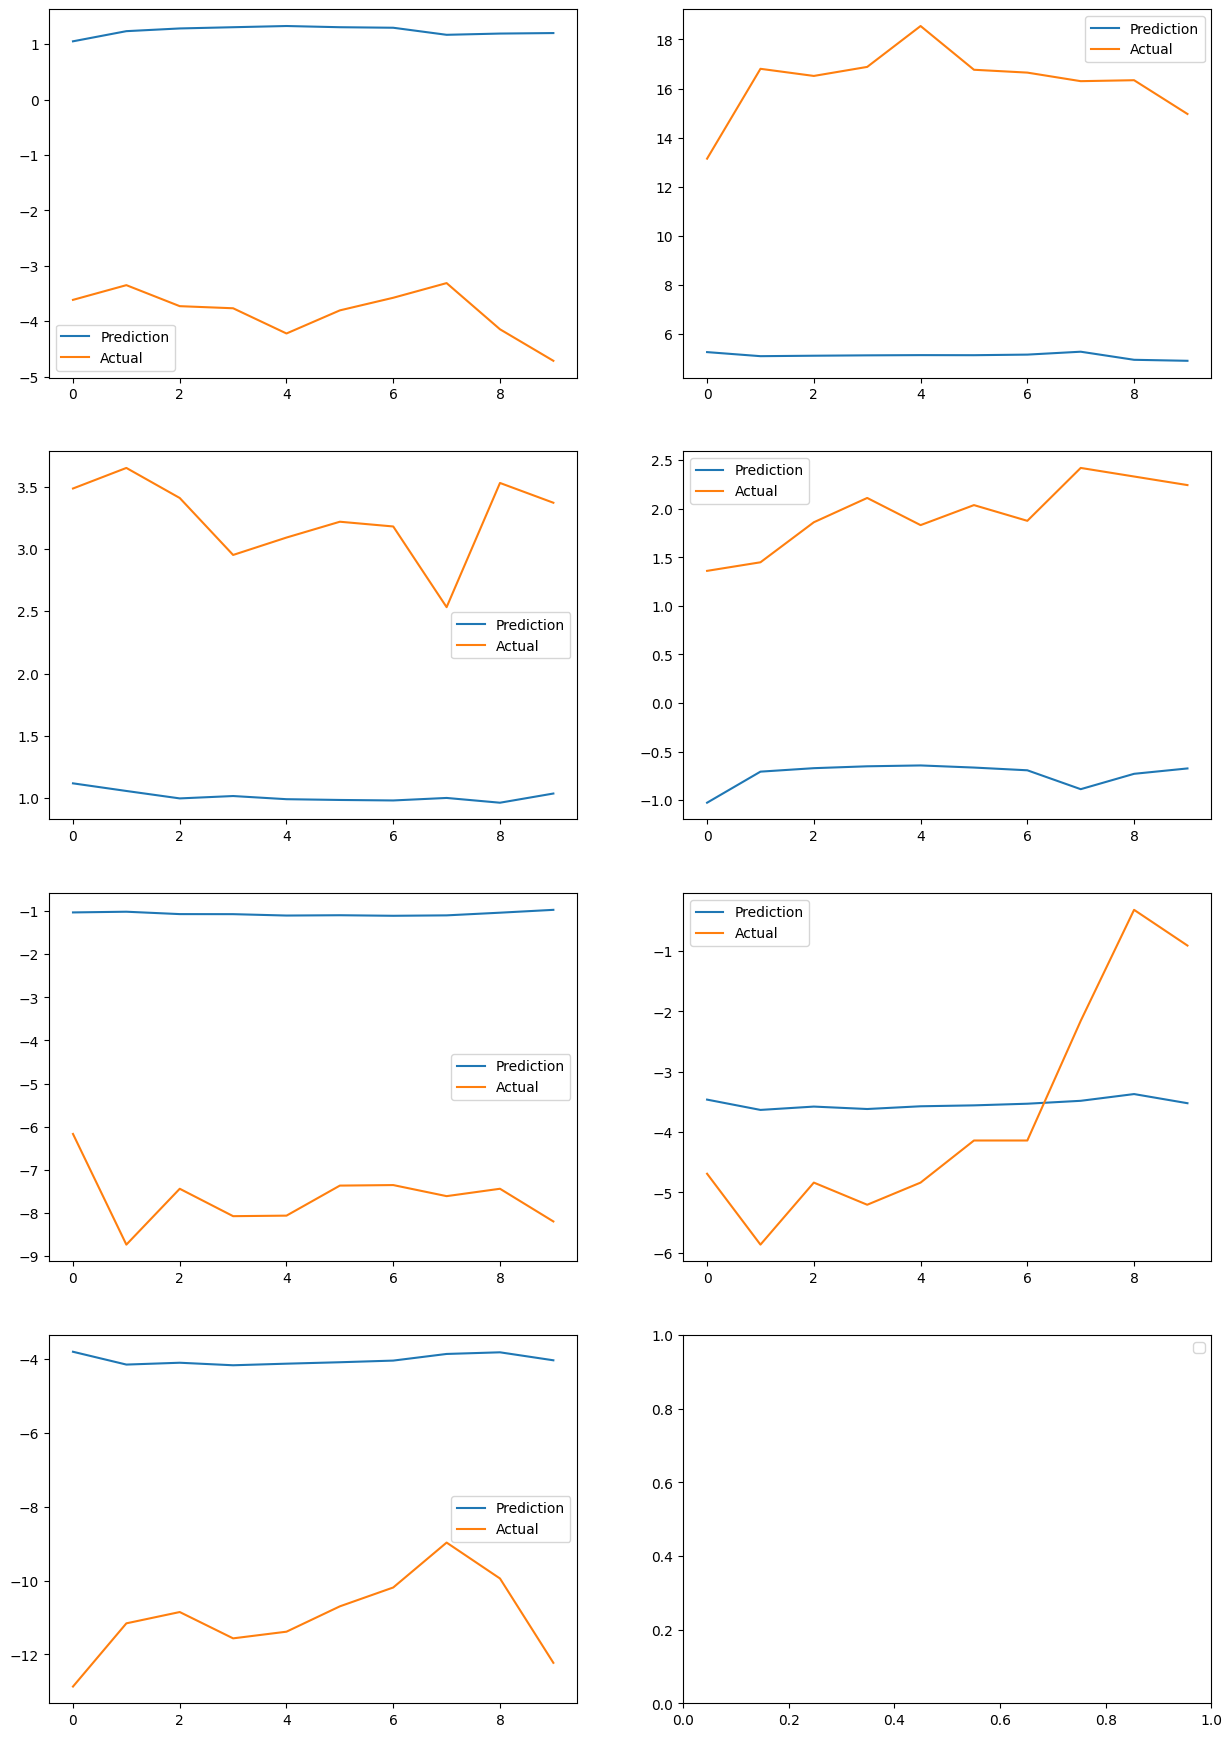

In [72]:
pred_plot_all(mod_60_DeSh, X_val60, y_val60)

In [35]:
# Default and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeLo[i].add(InputLayer((n,16)))
  mods_DeLo[i].add(GRU(64))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(15, "relu"))
  mods_DeLo[i].add(Dense(14, "relu"))
  mods_DeLo[i].add(Dense(7, "linear"))

  mods_DeLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_DeLo[i] = mods_DeLo[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 180,
      callbacks = [cps_DeLo[i], EarlyStopping(patience=5, start_from_epoch=10)])


  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/180
5/5 [==============================] - 8s 1s/step - loss: 26.4107 - root_mean_squared_error: 5.1391 - val_loss: 68.5678 - val_root_mean_squared_error: 8.2806
Epoch 2/180
5/5 [==============================] - 3s 865ms/step - loss: 26.3478 - root_mean_squared_error: 5.1330 - val_loss: 68.3929 - val_root_mean_squared_error: 8.2700
Epoch 3/180
5/5 [==============================] - 3s 862ms/step - loss: 26.2995 - root_mean_squared_error: 5.1283 - val_loss: 68.2372 - val_root_mean_squared_error: 8.2606
Epoch 4/180
5/5 [==============================] - 4s 1s/step - loss: 26.2555 - root_mean_squared_error: 5.1240 - val_loss: 68.0843 - val_root_mean_squared_error: 8.2513
Epoch 5/180
5/5 [==============================] - 4s 1s/step - loss: 26.2113 - root_mean_squared_error: 5.1197 - val_loss: 67.9532 - val_root_mean_squared_error: 8.2434
Epoch 6/180
5/5 [==============================] - 3s 857ms/step - loss: 26.1655 - root_mean_squared_error: 5.115

In [114]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_DeLo[i].history['val_root_mean_squared_error'])
  ) + " = Default/Long best Val RMSE with samples sized " + str(n))
  print("\n")

2.9508824348449707 = Default/Long best Val RMSE with samples sized 25


2.218916893005371 = Default/Long best Val RMSE with samples sized 34


2.5402328968048096 = Default/Long best Val RMSE with samples sized 45


6.419360637664795 = Default/Long best Val RMSE with samples sized 60




1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 91ms/step


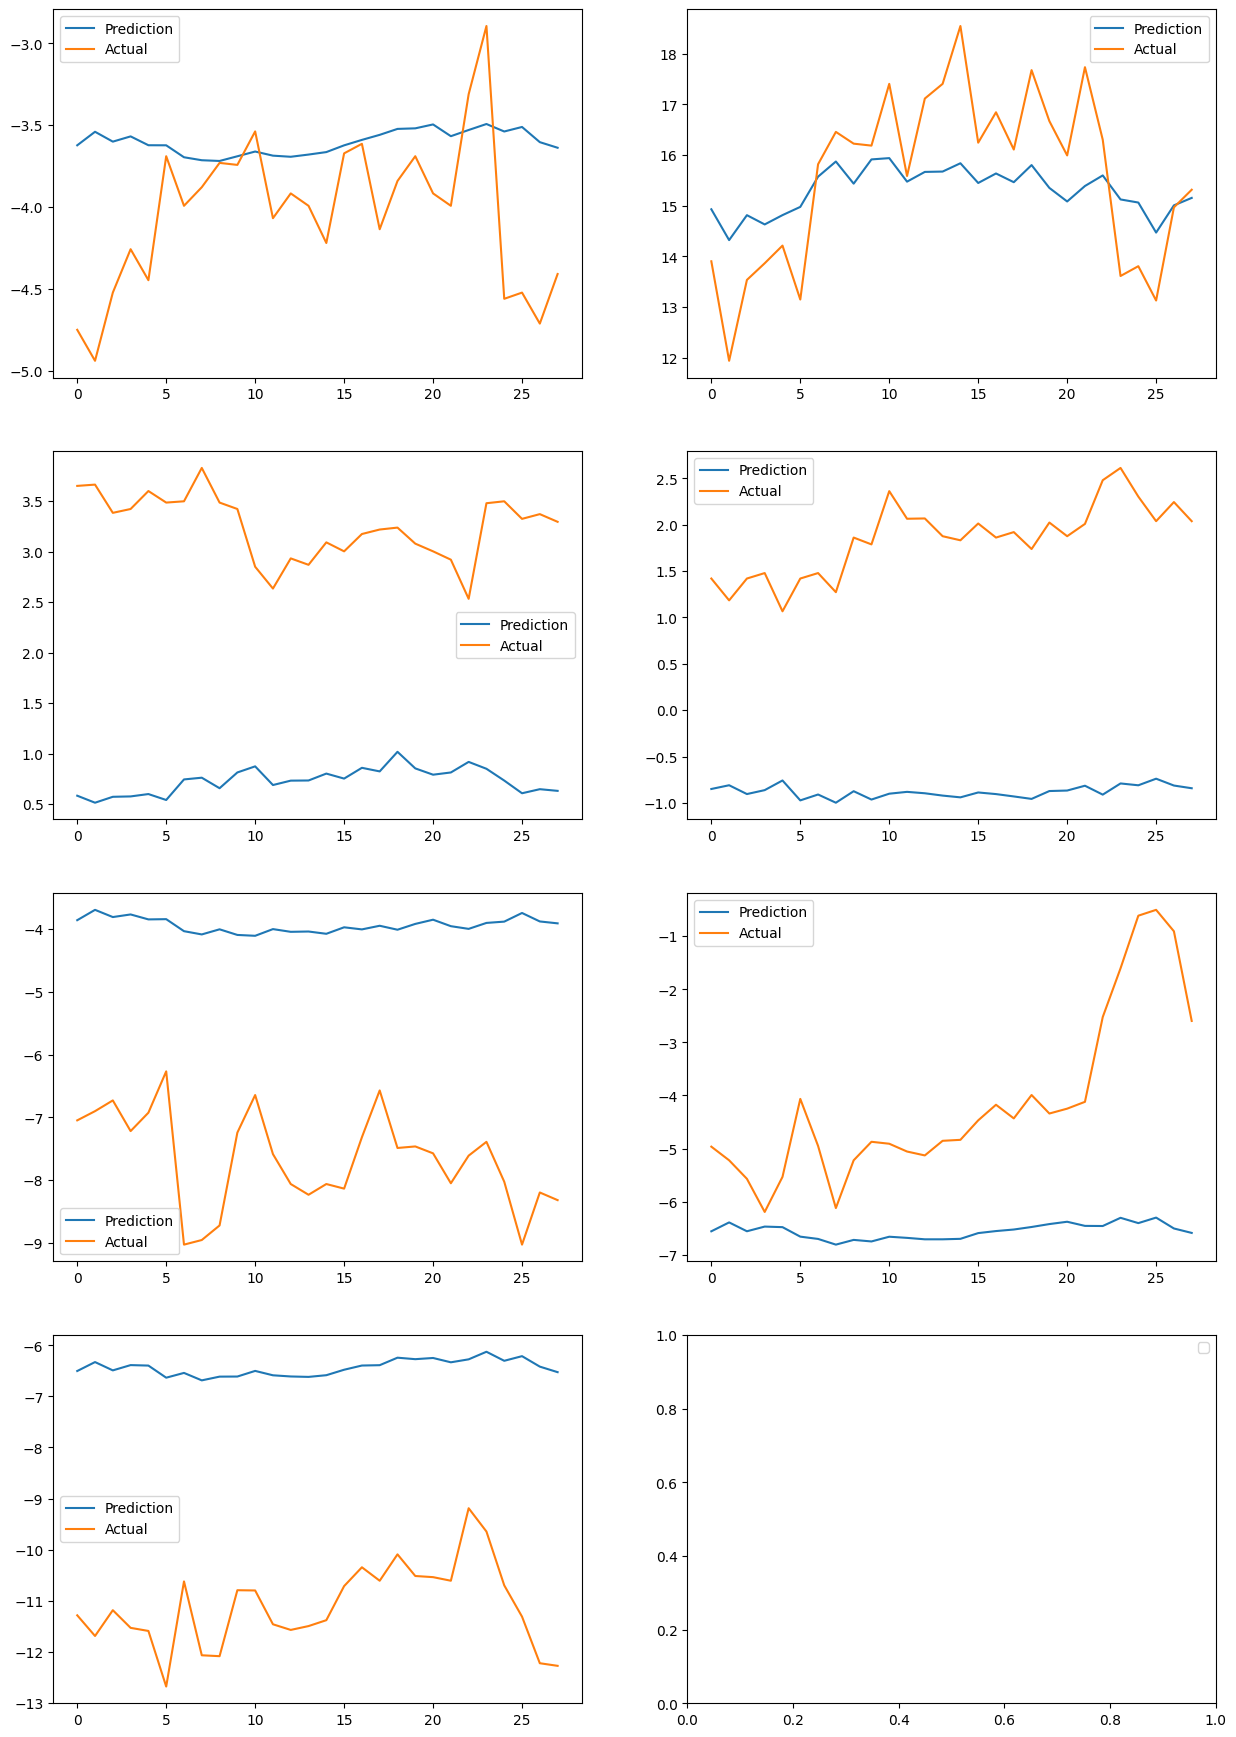

In [73]:
pred_plot_all(mod_25_DeLo, X_val25, y_val25)

In [37]:
# Fast and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaSh[i].add(InputLayer((n,16)))
  mods_FaSh[i].add(GRU(64))
  mods_FaSh[i].add(Dense(16, "relu"))
  mods_FaSh[i].add(Dense(14, "relu"))
  mods_FaSh[i].add(Dense(7, "linear"))

  mods_FaSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaSh[i] = mods_FaSh[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaSh[i], EarlyStopping(patience=4, start_from_epoch=6)])



  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 7s 1s/step - loss: 26.4512 - root_mean_squared_error: 5.1431 - val_loss: 66.5453 - val_root_mean_squared_error: 8.1575
Epoch 2/30
5/5 [==============================] - 4s 1s/step - loss: 22.8405 - root_mean_squared_error: 4.7792 - val_loss: 61.8513 - val_root_mean_squared_error: 7.8646
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 18.9854 - root_mean_squared_error: 4.3572 - val_loss: 48.5120 - val_root_mean_squared_error: 6.9651
Epoch 4/30
5/5 [==============================] - 3s 867ms/step - loss: 13.5703 - root_mean_squared_error: 3.6838 - val_loss: 31.4419 - val_root_mean_squared_error: 5.6073
Epoch 5/30
5/5 [==============================] - 4s 1s/step - loss: 9.5594 - root_mean_squared_error: 3.0918 - val_loss: 19.9510 - val_root_mean_squared_error: 4.4667
Epoch 6/30
5/5 [==============================] - 4s 889ms/step - loss: 7.9754 - root_mean_squared_error: 2.8241 - val_los

TypeError: 'History' object is not subscriptable

In [115]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_FaSh[i].history['val_root_mean_squared_error'])
  ) + " = Fast/Short best Val RMSE with samples sized " + str(n))
  print("\n")

TypeError: 'History' object is not subscriptable

In [ ]:
pred_plot_all(mod_25_FaSh, X_val25, y_val25)

In [ ]:
pred_plot_all(mod_34_FaSh, X_val34, y_val34)

In [ ]:
pred_plot_all(mod_45_FaSh, X_val45, y_val45)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 67ms/step


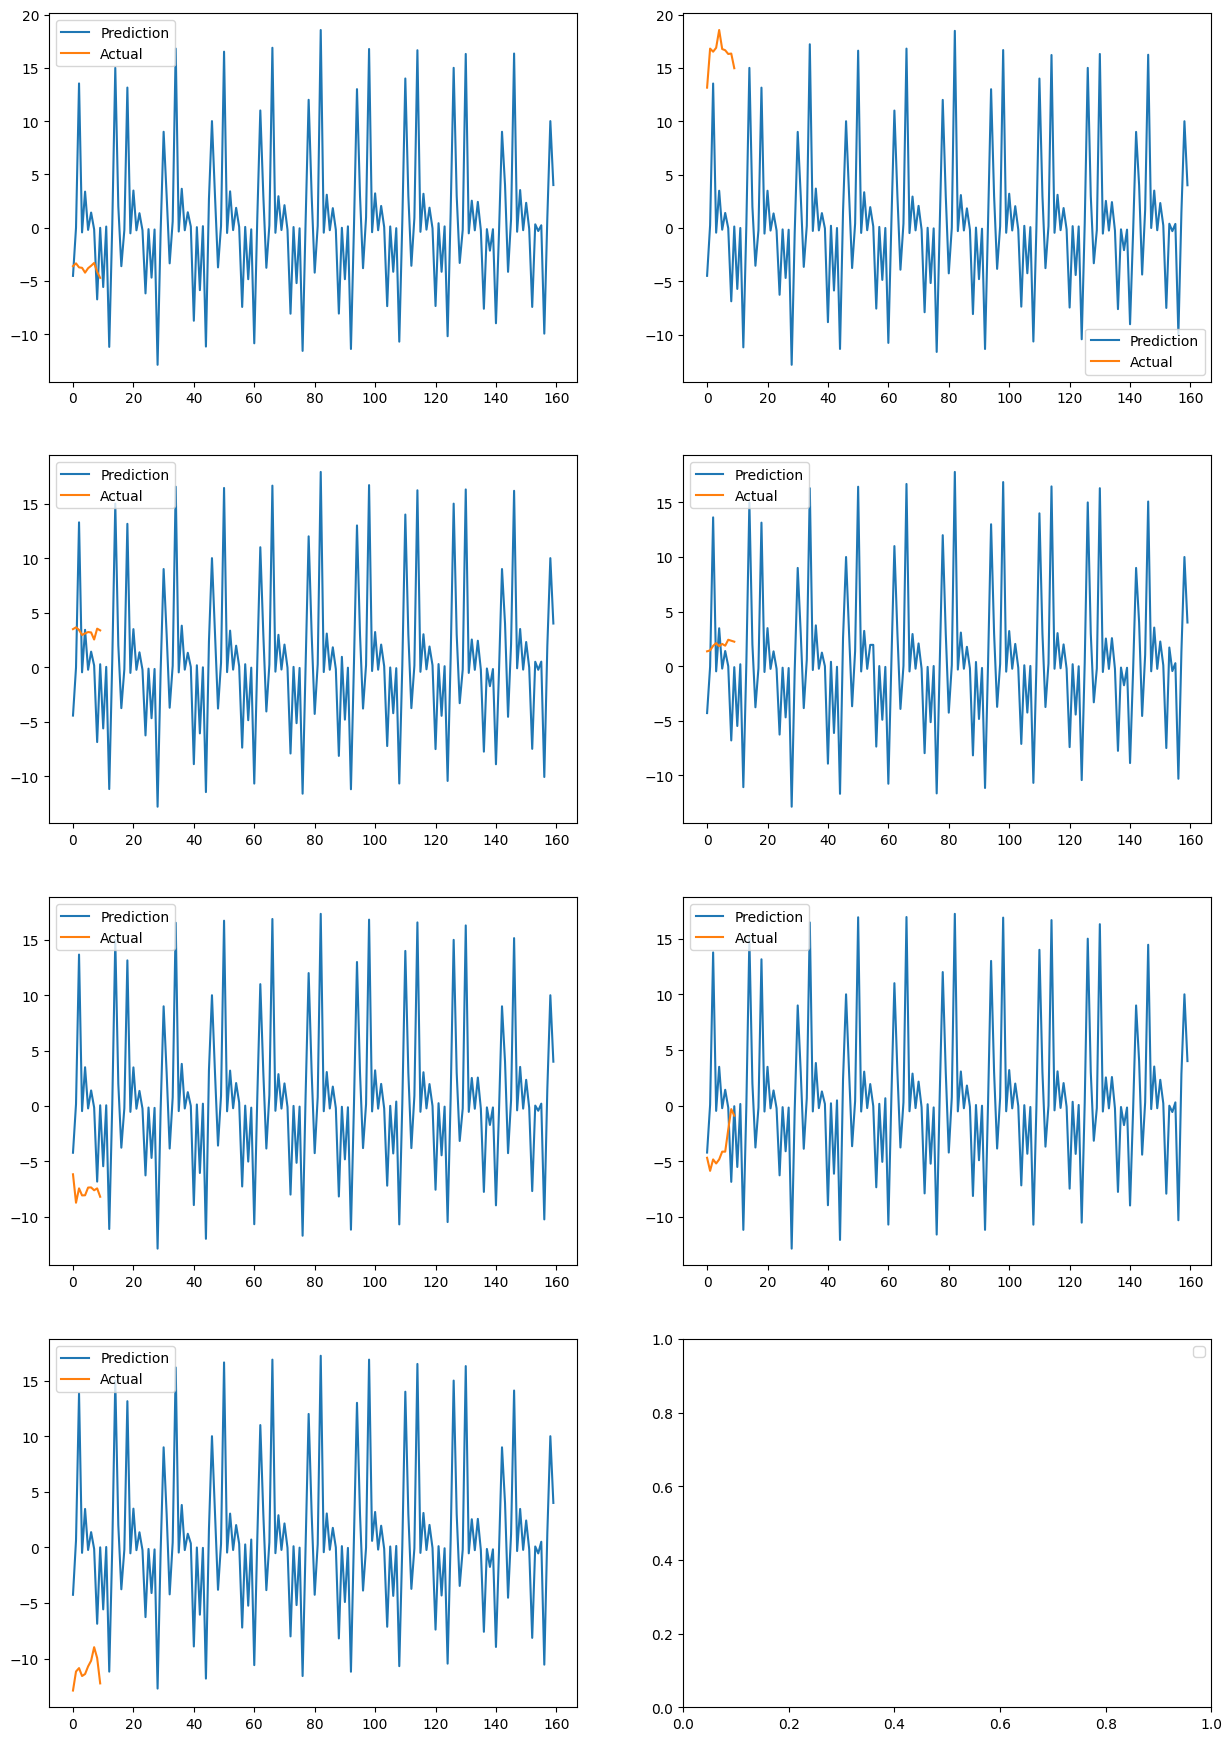

In [76]:
pred_plot_all(mod_60_FaSh, X_val60, y_val60)

In [41]:
# Fast and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaLo[i].add(InputLayer((n,16)))
  mods_FaLo[i].add(GRU(64))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(15, "relu"))
  mods_FaLo[i].add(Dense(14, "relu"))
  mods_FaLo[i].add(Dense(7, "linear"))

  mods_FaLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaLo[i] = mods_FaLo[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaLo[i], EarlyStopping(patience=4, start_from_epoch=6)])

  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 7s 996ms/step - loss: 25.8999 - root_mean_squared_error: 5.0892 - val_loss: 63.9039 - val_root_mean_squared_error: 7.9940
Epoch 2/30
5/5 [==============================] - 4s 1s/step - loss: 21.2833 - root_mean_squared_error: 4.6134 - val_loss: 45.5982 - val_root_mean_squared_error: 6.7526
Epoch 3/30
5/5 [==============================] - 4s 896ms/step - loss: 13.6455 - root_mean_squared_error: 3.6940 - val_loss: 25.0712 - val_root_mean_squared_error: 5.0071
Epoch 4/30
5/5 [==============================] - 4s 1s/step - loss: 8.8054 - root_mean_squared_error: 2.9674 - val_loss: 15.5211 - val_root_mean_squared_error: 3.9397
Epoch 5/30
5/5 [==============================] - 4s 1s/step - loss: 7.2843 - root_mean_squared_error: 2.6989 - val_loss: 9.8388 - val_root_mean_squared_error: 3.1367
Epoch 6/30
5/5 [==============================] - 4s 929ms/step - loss: 6.7219 - root_mean_squared_error: 2.5927 - val_lo

In [124]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_FaLo[i].history['val_root_mean_squared_error'])
  ) + " = Fast/Long best Val RMSE with samples sized " + str(n))
  print("\n")

1.8798028230667114 = Fast/Long best Val RMSE with samples sized 25


1.5918505191802979 = Fast/Long best Val RMSE with samples sized 34


1.9816744327545166 = Fast/Long best Val RMSE with samples sized 45


1.9438639879226685 = Fast/Long best Val RMSE with samples sized 60




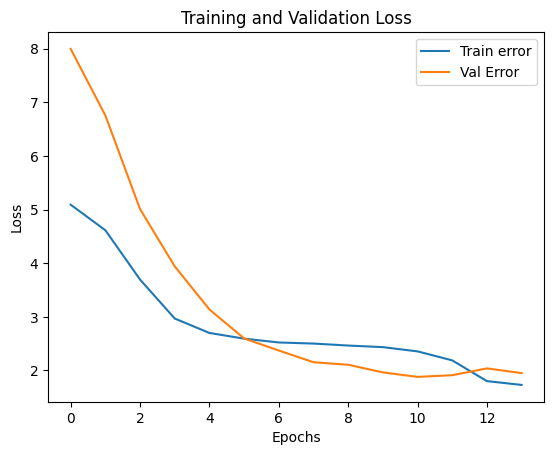

In [122]:
plot_error(hists_FaLo[0])

1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 44ms/step


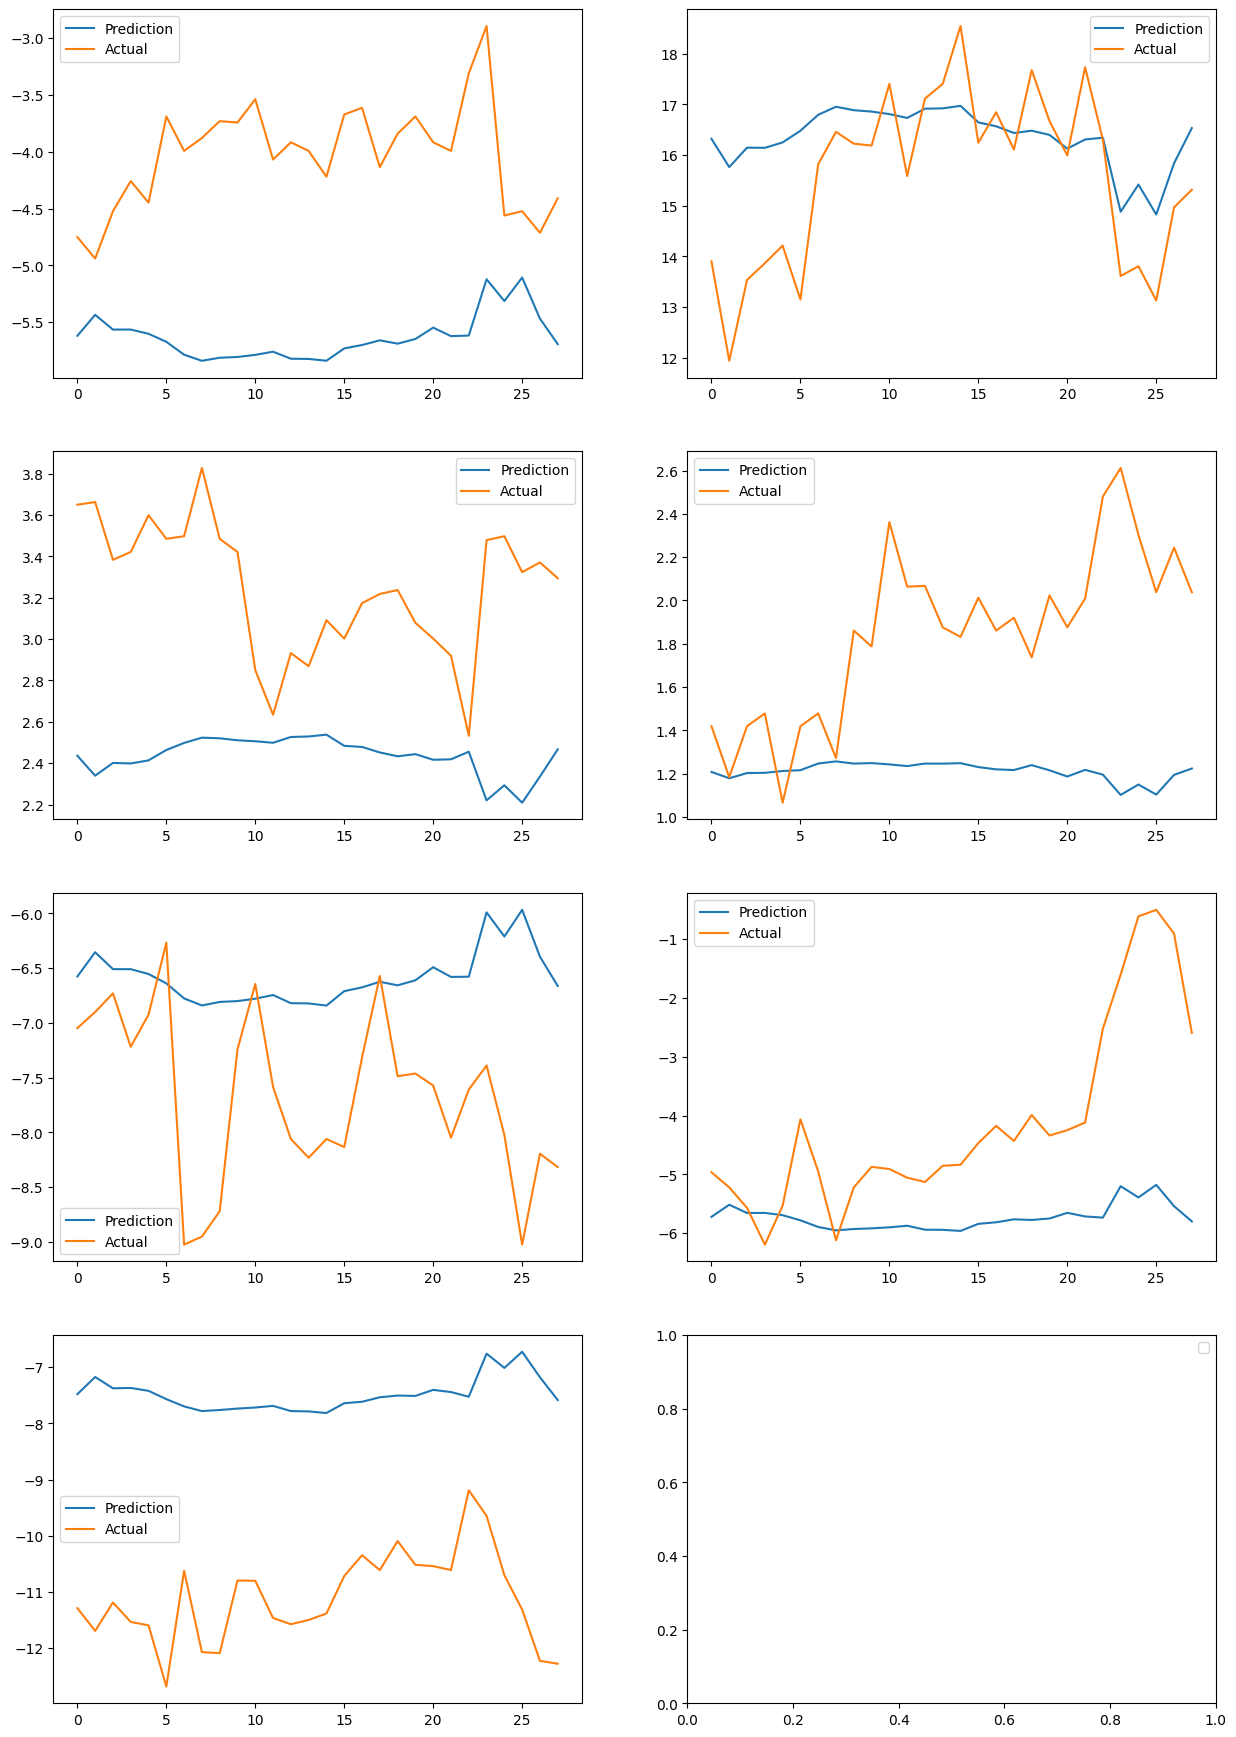

In [78]:
 pred_plot_all(mod_25_FaLo, X_val25, y_val25)

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


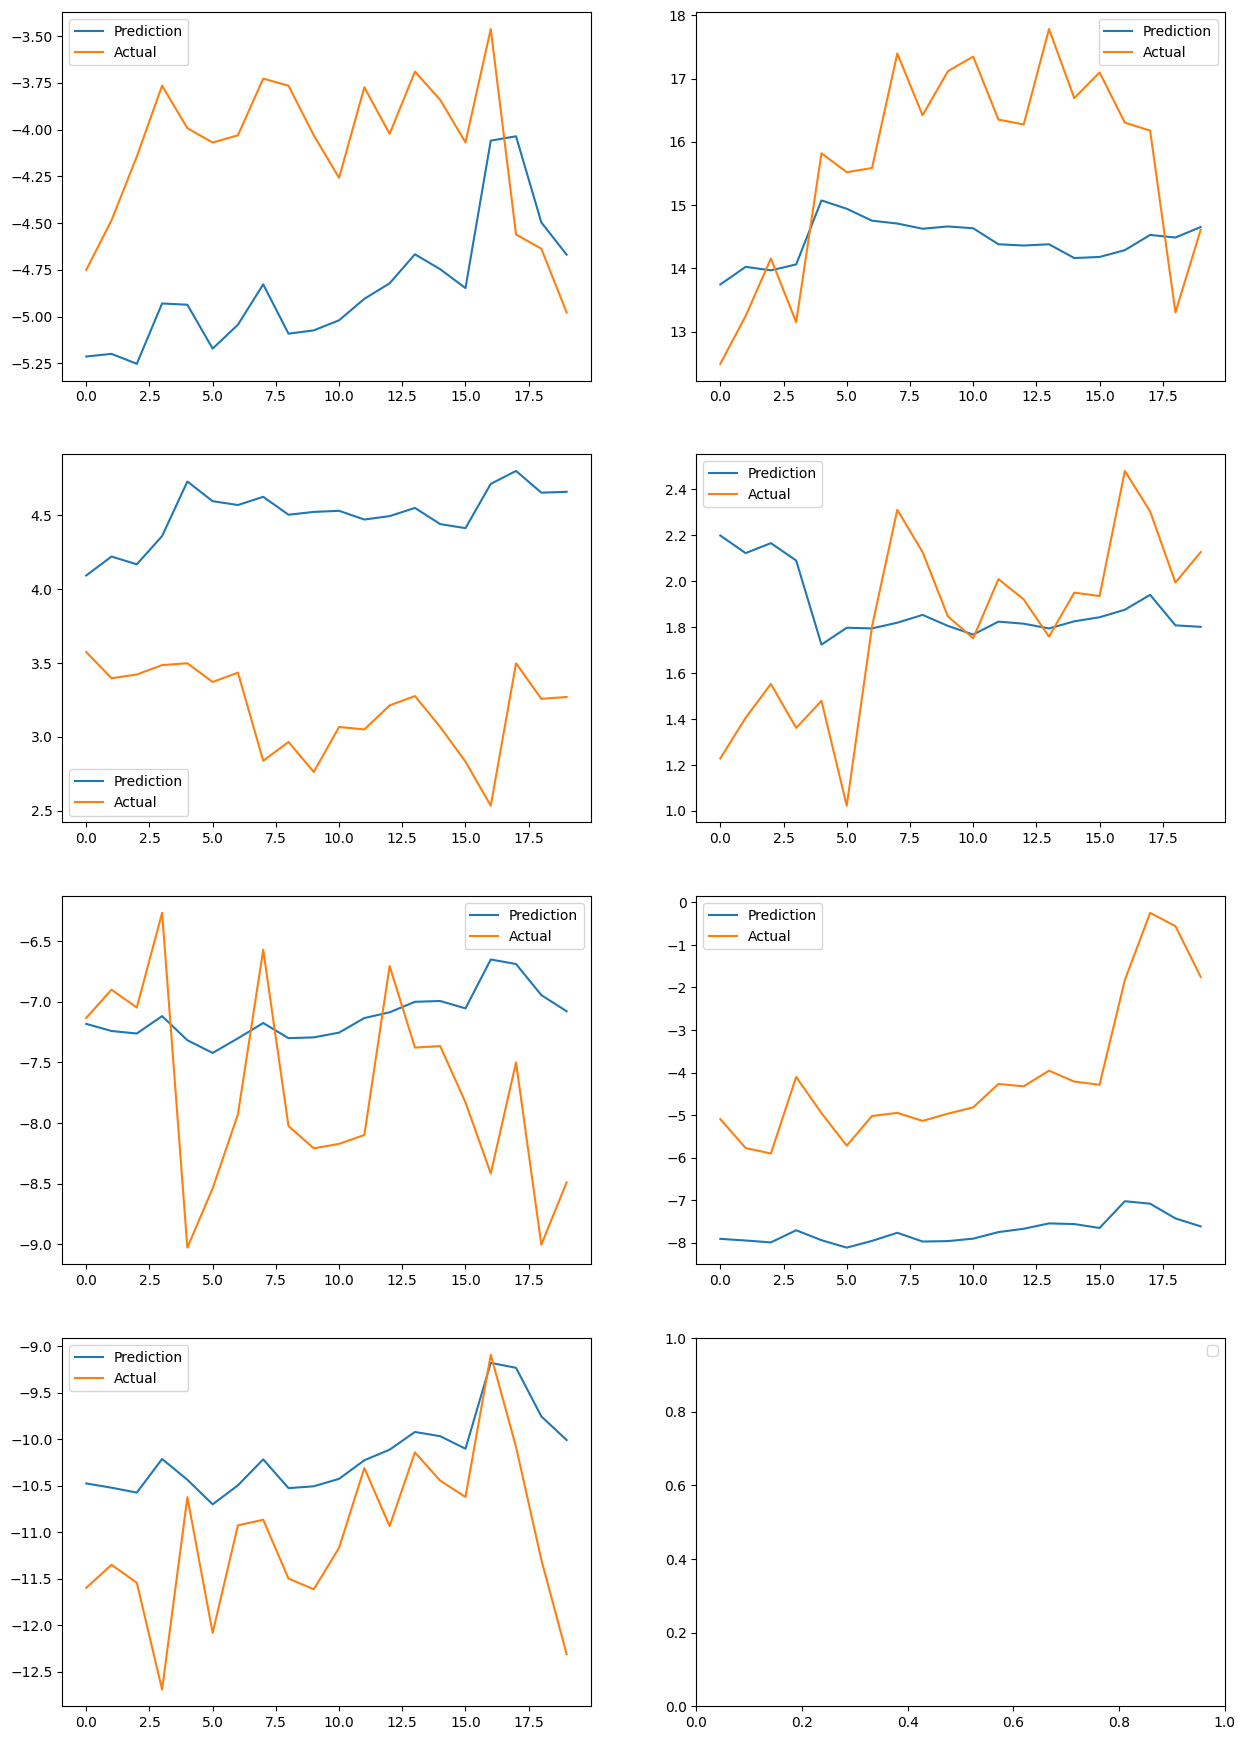

In [77]:
pred_plot_all(mod_34_FaLo, X_val34, y_val34)

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


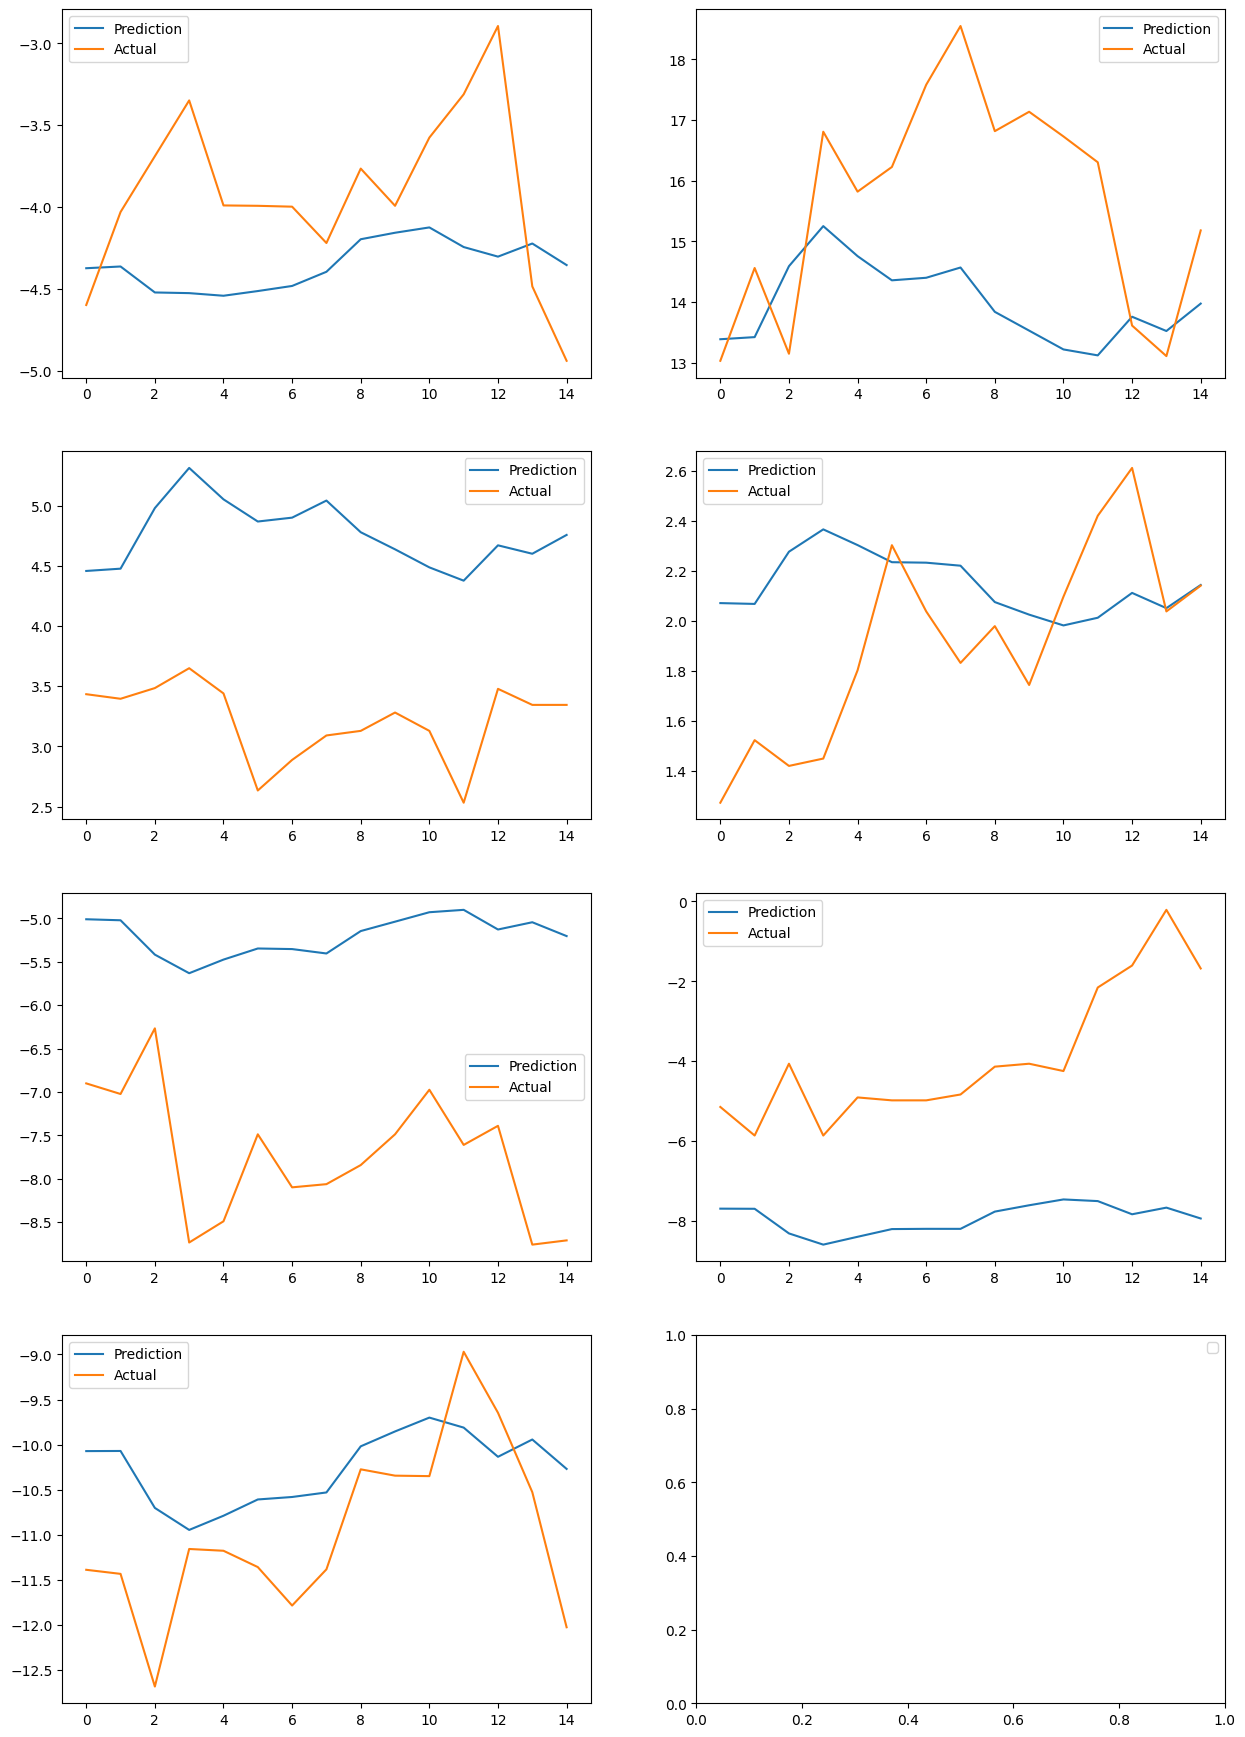

In [79]:
pred_plot_all(mod_45_FaLo, X_val45, y_val45)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


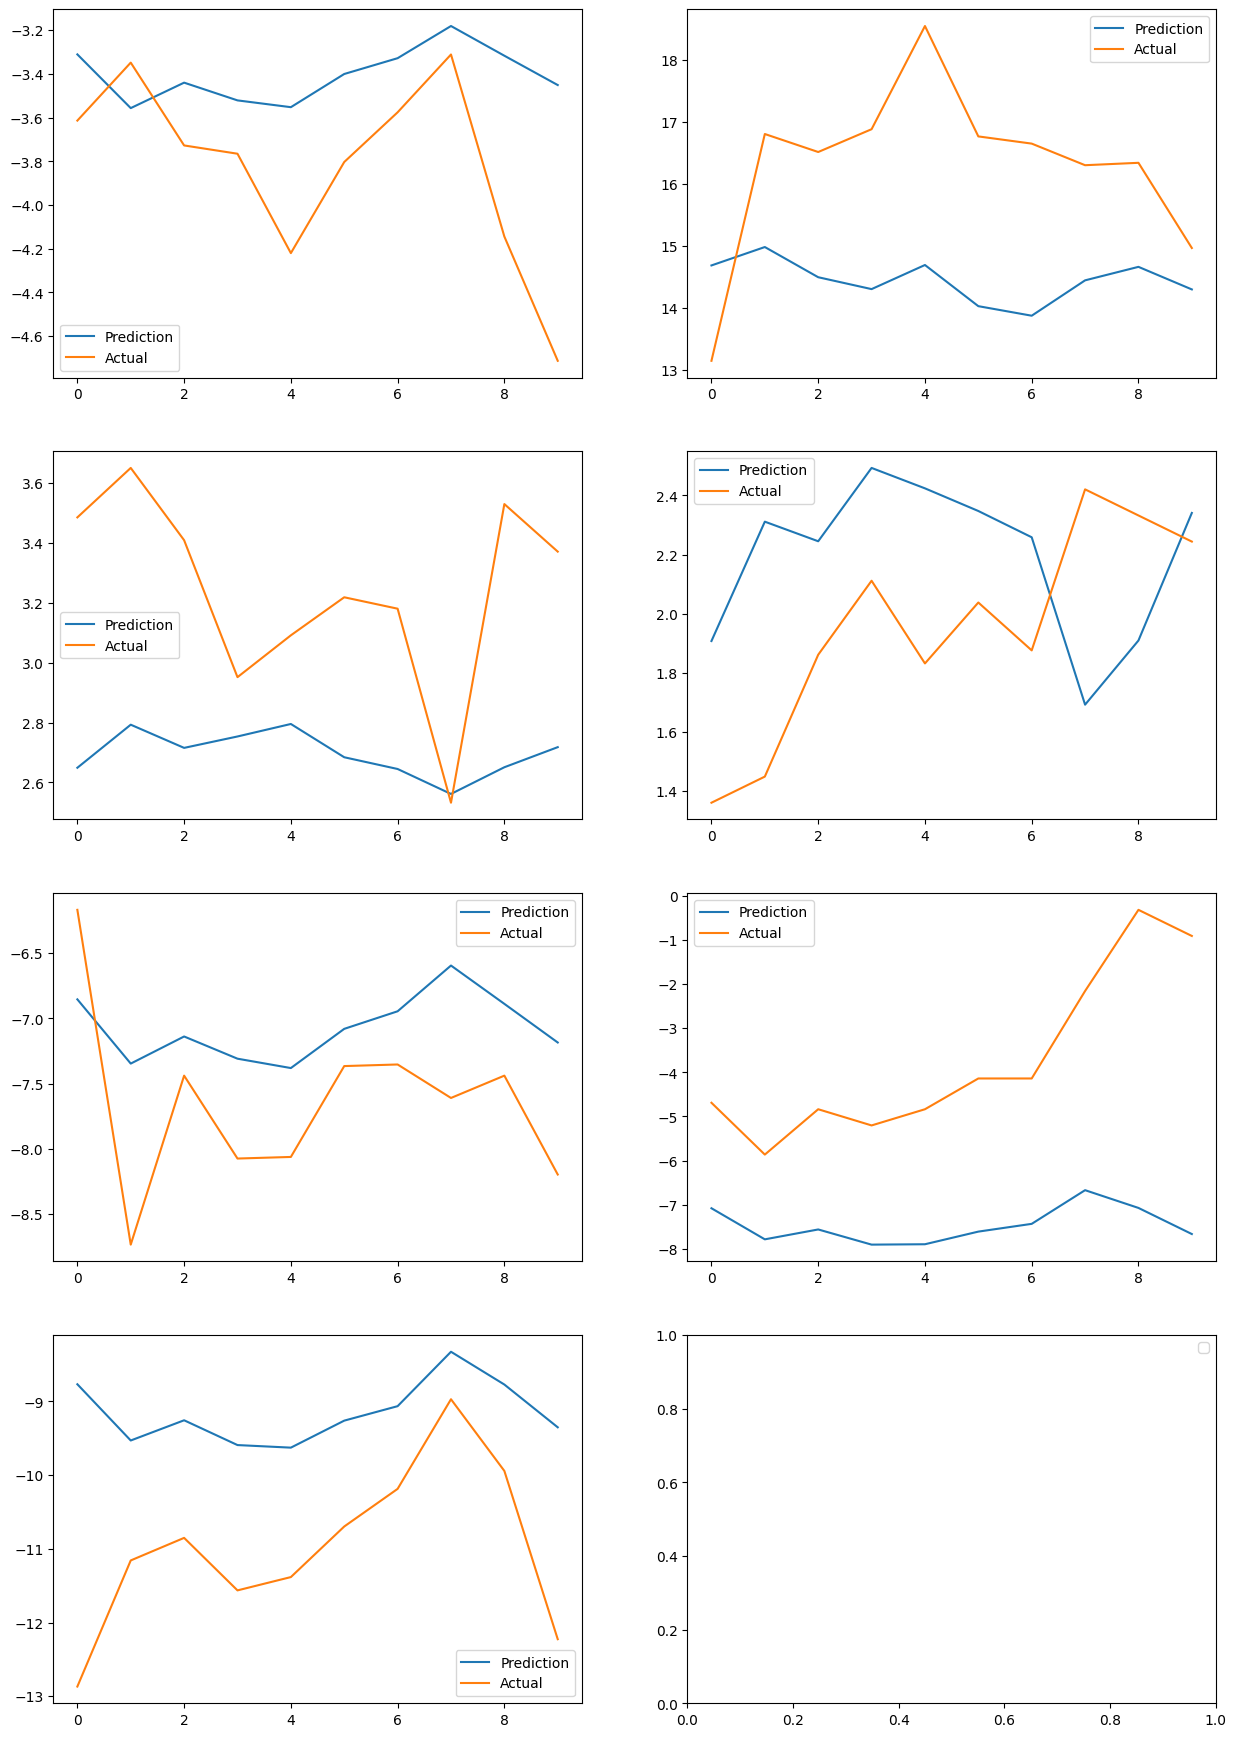

In [80]:
pred_plot_all(mod_60_FaLo, X_val60, y_val60)

In [129]:
rmse = RootMeanSquaredError()
rmse.update_state(y_true=y_test34, y_pred=mod_34_FaLo.predict(X_test34))
print("Root Mean Squared Error:", rmse.result().numpy())

1/1 [==============================] - 0s 66ms/step
Root Mean Squared Error: 2.2063396


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 55ms/step


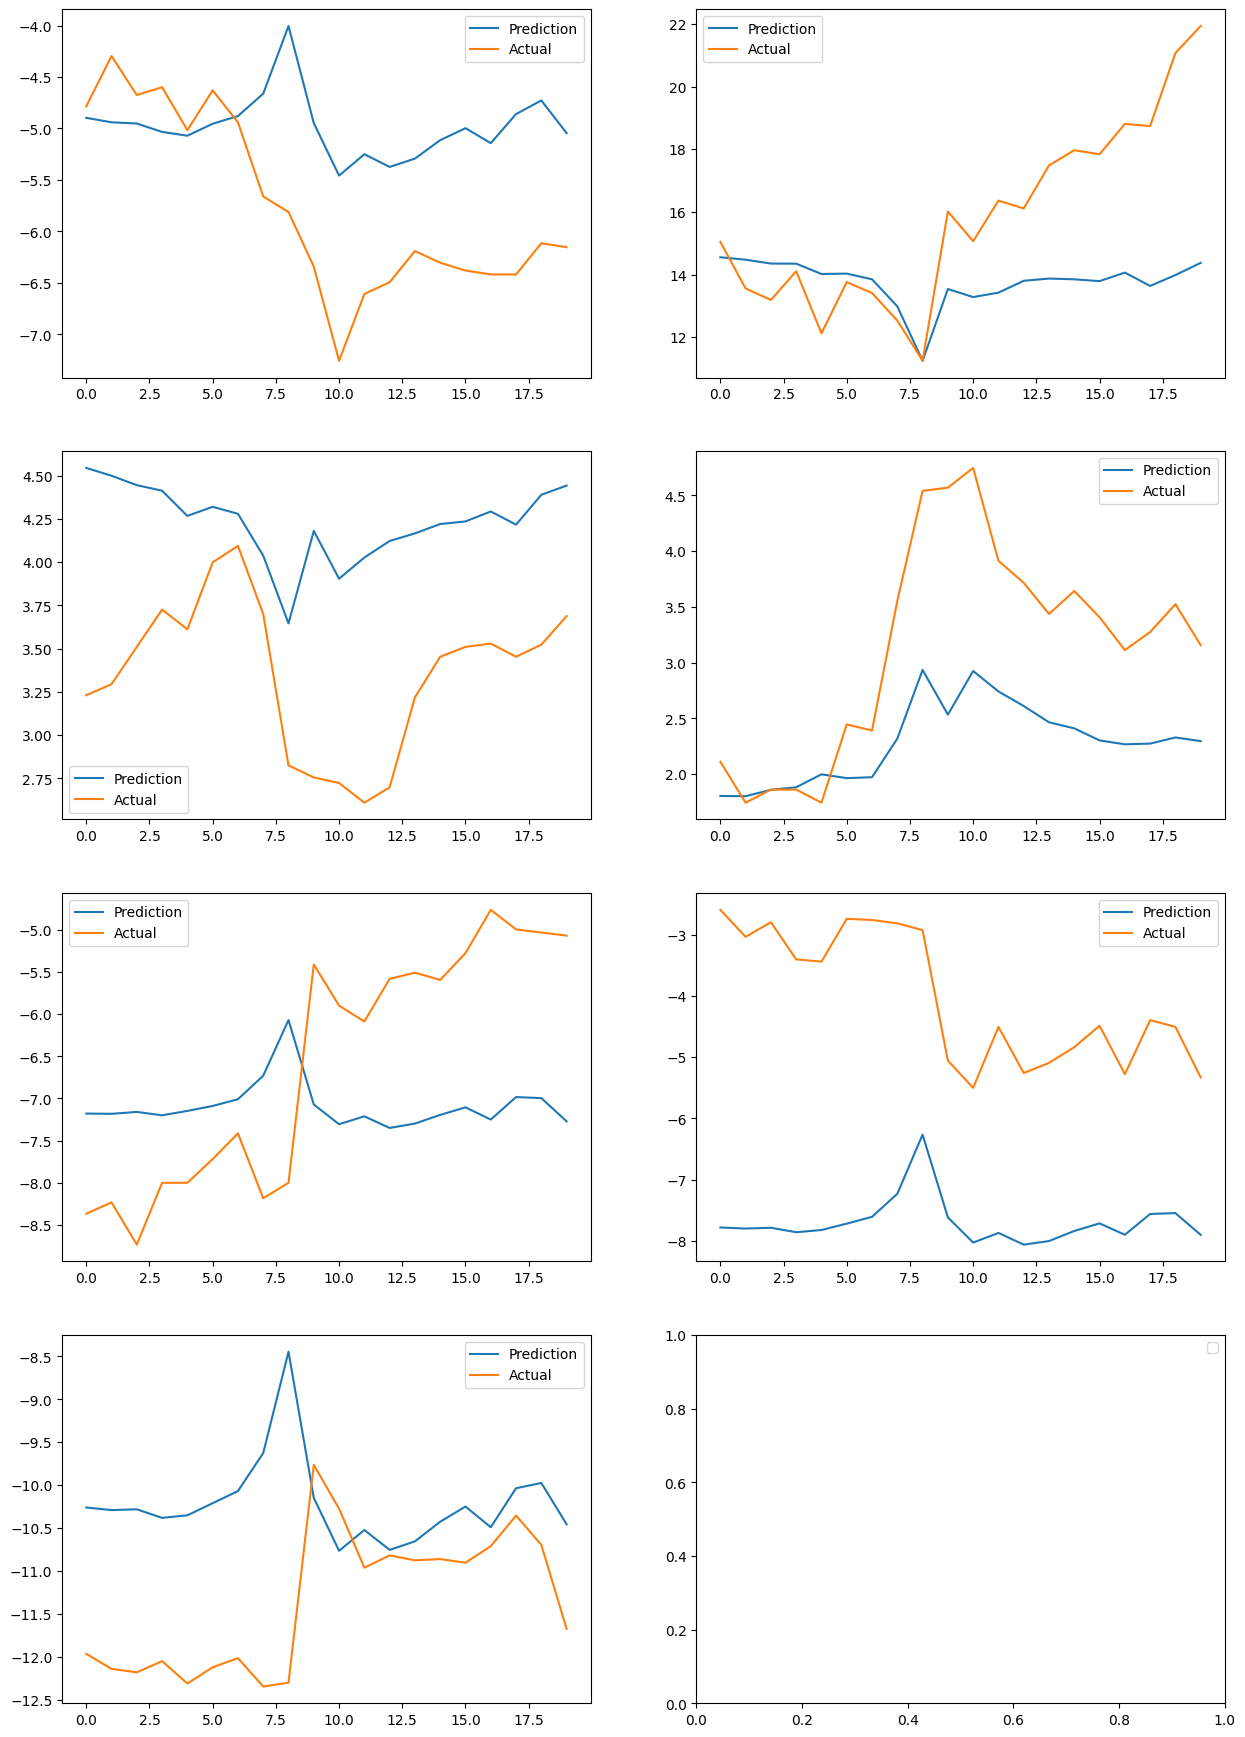

In [130]:
pred_plot_all(mod_34_FaLo, X_test34, y_test34)